In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
FAST_RUN=False
batch_size=32
epochs=100
if FAST_RUN:
    epochs=1

In [4]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [5]:
print(train_data.columns)

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)


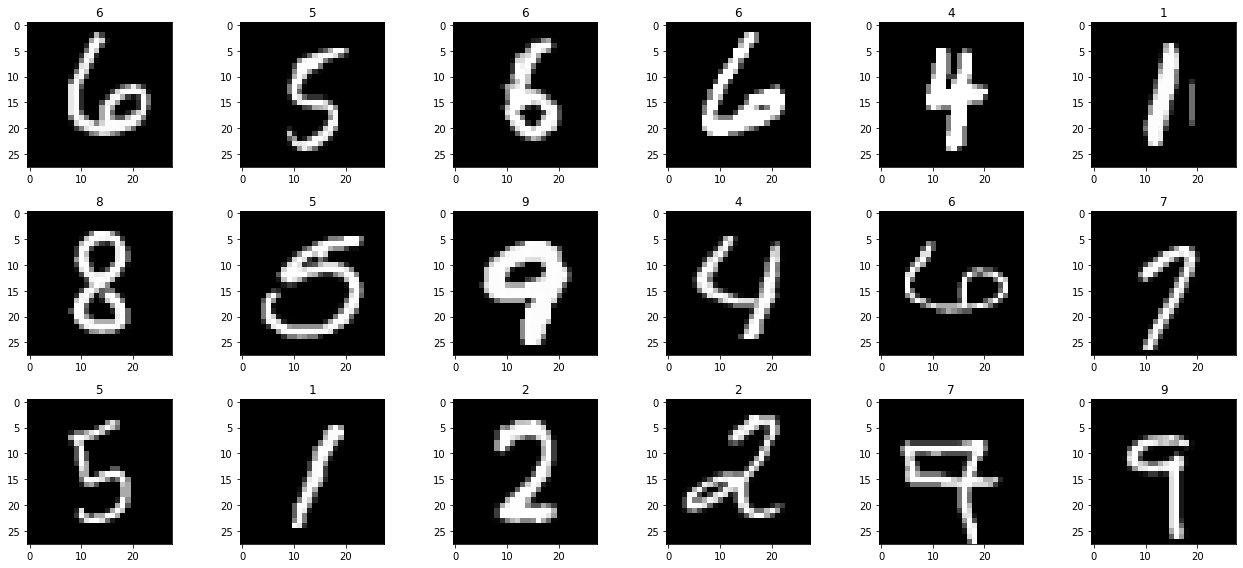

In [6]:
def show_image(train_image, label, index):
    image_shaped = train_image.values.reshape(28,28)
    plt.subplot(3, 6, index+1)
    plt.imshow(image_shaped, cmap=plt.cm.gray)
    plt.title(label)


plt.figure(figsize=(18, 8))
sample_image = train_data.sample(18).reset_index(drop=True)
for index, row in sample_image.iterrows():
    label = row['label']
    image_pixels = row.drop('label')
    show_image(image_pixels, label, index)
plt.tight_layout()


In [7]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

x = train_data.drop(columns=['label']).values.reshape(train_data.shape[0],28,28,1)
y = to_categorical(train_data['label'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_datagen.fit(x_train)
train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
train_datagen.fit(x_test)
validation_generator = validation_datagen.flow(
    x_test,
    y_test
    
)

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [10]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [12]:
 model.fit(
    train_generator, 
    steps_per_epoch=len(x_train), 
    validation_data=validation_generator,
    validation_steps=len(x_test),
    epochs=epochs,
    callbacks=callbacks
    )

Epoch 1/100
 1182/37800 [..............................] - ETA: 47:14 - loss: 0.3721 - accuracy: 0.8845WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 3780000 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: val_loss improved from inf to 0.08476, saving model to model.h5
37800/37800 [==============================] - 98s 3ms/step - loss: 0.3721 - accuracy: 0.8845 - val_loss: 0.0848 - val_accuracy: 0.9774 - lr: 0.0010


In [13]:
x_test_recaled = (x_test.astype("float32") / 255)
scores = model.evaluate(x_test_recaled, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))

accuracy: 97.74%
loss: 8.48%


In [14]:
test_digit_data = test_data.values.reshape(test_data.shape[0],28,28,1).astype("float32") / 255
predictions = model.predict(test_digit_data)
results = np.argmax(predictions, axis = 1) 

875/875 [==============================] - 14s 16ms/step


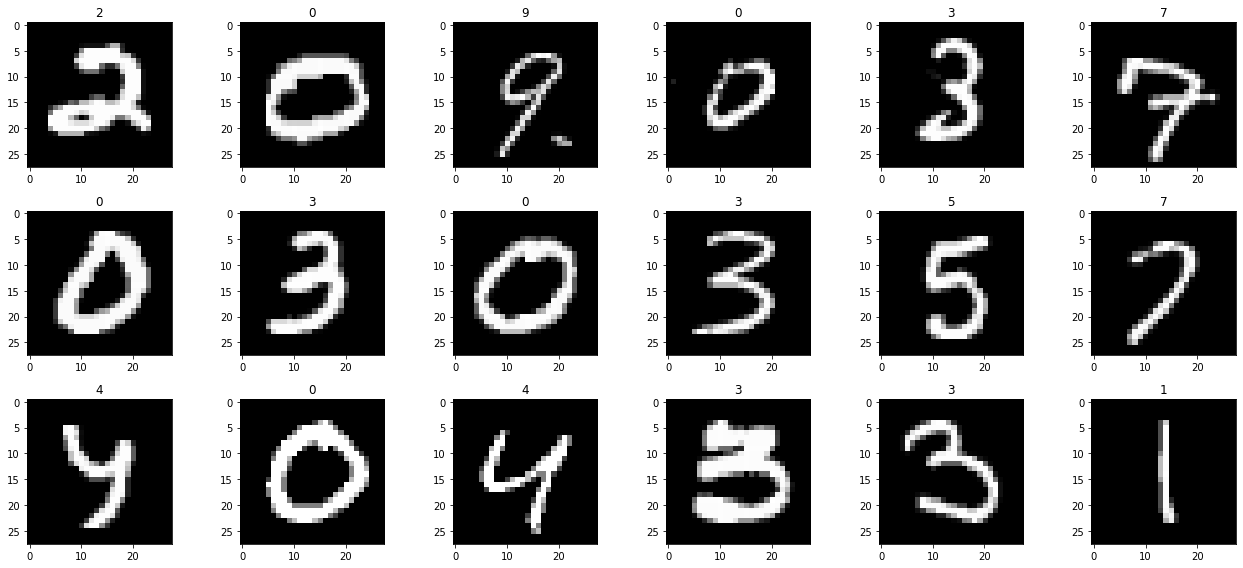

In [15]:
plt.figure(figsize=(18, 8))
sample_test = test_data.head(18)
for index, image_pixels in sample_test.iterrows():
    label = results[index]
    show_image(image_pixels, label, index)
plt.tight_layout()

In [16]:
submissions = pd.read_csv('sample_submission.csv')
submissions['Label'] = results
submissions.to_csv('submission.csv', index = False)